In [59]:
import os

os.chdir('/Users/boranw/Library/Mobile Documents/com~apple~CloudDocs/Ryan Wang /Columbia/Niko/Face in RNNs/BLT_recurrent_models')

from analyze_representations import sample_vggface2, calc_rdms, plot_maps, compare_rdms,\
  plot_recurrent_rdms, reduce_dim, plot_dim_reduction_one, sample_FEI_dataset, \
  plot_rdm_mds, load_model_path, load_pretrained_models, extract_features, kasper_dataset, \
  get_activations_batch, FBO_dataset #, calc_dprime


os.chdir('/Volumes/kriegeskorte-locker/hossein/recurrent_models/BLT_models')
!pwd

%matplotlib inline 
import matplotlib.pyplot as plt

import datasets
import pandas as pd
import numpy as np
import csv
import torch
from matplotlib.patches import Rectangle
import torchvision
from PIL import Image
#from models.cornet import get_cornet_model
import torch.nn as nn
from collections import OrderedDict
import rsatoolbox
import torch.nn.functional as F
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]  # Standard deviation used for normalization

def denormalize(tensor):
    """Denormalizes a tensor image."""
    # Create an inverse transform
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Convert the tensor to a PIL Image
    to_pil = transforms.ToPILImage()
    image = to_pil(inv_normalize(tensor))

    return image

/Volumes/kriegeskorte-locker/hossein/recurrent_models/BLT_models


In [54]:
# add dataset FBO as an option
# add imagenet_vggface2 as an option
args = {}
args['zscore'] = 0
args['clip_values'] = 0
args['output_layer'] = 'output_5' #'norm_5'

args['face_dataset'] = 'kasper'

### Load the dataset of faces and objects 

The dataset is from Vinken et al (2023).

The faces in this dataset could be occluded and in different orientations. So not as clean as
frontal faces. 

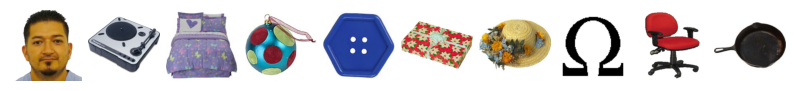

In [55]:
# load the dataset
imgs, labels, neuro_data = kasper_dataset()
imgs_gray = torchvision.transforms.functional.rgb_to_grayscale(imgs, num_output_channels=3)

if args['face_dataset'] == 'kasper':

    imgs = imgs[labels != 1]
    neuro_data = neuro_data[labels != 1]
    imgs_gray = imgs_gray[labels != 1]
    labels = labels[labels != 1]

    num_faces = len(labels[labels == 0])

# elif args['face_dataset'] == 'FEI':
#     FEI_imgs, _, _, FEI_labels_i = sample_FEI_dataset(num_ids=25, orientation_inds=np.arange(1,15))
#     num_faces = len(FEI_imgs)

#     non_face_images = imgs[labels == 2]

#     imgs = torch.cat((FEI_imgs, non_face_images))

#     labels = np.concatenate((np.zeros(len(FEI_imgs)), np.ones(len(non_face_images))))



# Display a few images
n = 10
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, n)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
img_inds = np.random.choice(len(imgs), n, replace=False)
img_inds = img_inds[np.argsort(labels[img_inds])]
for i in range(n):
    ax = fig.add_subplot(gs[i])
    ax.imshow(denormalize(imgs[img_inds[i]]))
    ax.axis('off')


Some helper functions to extract featurs from the network and to calculate d-prime

In [56]:
def range_normalize(array, axis=0):
    # Find the min and max for each row
    min_vals = array.min(axis=axis, keepdims=True)
    max_vals = array.max(axis=axis, keepdims=True)
    
    # Normalize each row
    normalized_array = (array - min_vals) / (max_vals - min_vals)
    normalized_array[np.isnan(normalized_array)] = 0
    return normalized_array

def extract_model_features(model, imgs, layer, num_steps=5):

    try:
        model = model.module
    except:
        model = model

    num_chunks = len(imgs) // 64
    chunks = torch.chunk(imgs, num_chunks, dim=0)

    outputs = []
    for chunk in chunks:
        output = get_activations_batch(model, chunk, layer=layer, sublayer='output')

        #output = np.clip(output, a_max=np.percentile(output, 99), a_min=0)

        # if filter_units is not None:
        #     output = output[:, :, filter_units, :] # only take the last time-step
        #     print(output.shape)

        # average pooling over spatial dimensions in higher layers
        if layer == 'output_4' or layer == 'output_5' or layer == 'norm_5':
            # TODO: max or mean, that is the question
            output = output.reshape(*output.shape[:3], -1).mean(-1)
        else:
            output = output.reshape(*output.shape[:2], -1)

        outputs.append(output)

    output = np.concatenate(outputs, axis=1)

    features = {}
    average_features = []
    for t in range(len(output)-num_steps,len(output)):

        #output[t] = np.clip(output[t], a_max=np.percentile(output[t], 99), a_min=0)

        model_resp= output[t].copy() # 
        # TODO: z-score or range normalize or neither? 
        # Maybe if the data is after relu, we just don't do anything
        if args['zscore']:
            model_resp = stats.zscore(model_resp, axis=1)

        if args['clip_values']:
            model_resp = np.clip(model_resp, a_max=np.percentile(model_resp, 95), a_min=np.percentile(model_resp, 5))
        
        

        #model_resp = range_normalize(model_resp, 0)
        output[t] = model_resp  

        #print(model_resp.shape)
        features[f'step {t}'] = output[t]  #/ np.max(output[t])
        average_features.append(features[f'step {t}'])

    # should I clip activations before averaging?

    features['average'] = np.mean(average_features, axis=0)
    return features

def calc_dprime(model_resp):

    #model_resp = stats.zscore(model_resp, axis=1)
    face_num = 230
    face_resp = model_resp[:,:face_num]
    non_face_resp = model_resp[:,face_num:]
    d_prime = np.mean(face_resp, axis=1) - np.mean(non_face_resp, axis=1)
    d_prime = d_prime / np.sqrt(np.var(face_resp, axis=1)/2 + np.var(non_face_resp, axis=1)/2)

    return d_prime

Question:

- What are the appropriate preprocessing for the neural data? 

- Should we z-score the activity across images for a unit for each time-step? 

- Should we normalize across time-steps? 

### Load our recurrent model. 

 We can get that before relu  and normalize ourselves. 

Number of model parameters: 22484904
blt(
  (conv_input): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (pool_input): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (output_prenorm_0): Identity()
  (non_lin_0): ReLU(inplace=True)
  (norm_0): GroupNorm(32, 64, eps=1e-05, affine=True)
  (output_0): Identity()
  (conv_0_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_0_1): Sequential(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (output_prenorm_1): Identity()
  (non_lin_1): ReLU(inplace=True)
  (norm_1): GroupNorm(32, 128, eps=1e-05, affine=True)
  (output_1): Identity()
  (conv_1_1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1_2): Sequential(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv): Conv

(array([ 66., 609., 760., 309., 161.,  77.,  39.,  12.,   3.,   2.]),
 array([-1.23004627, -0.82925481, -0.42846334, -0.02767181,  0.37311959,
         0.773911  ,  1.17470264,  1.57549405,  1.97628546,  2.37707686,
         2.77786851]),
 <BarContainer object of 10 artists>)

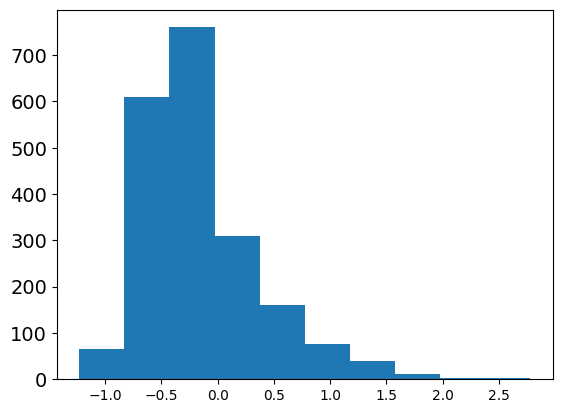

In [ ]:
# This model is trained using categories from ImageNet and faces from VGGFace2
model,  = load_model_path('./results/classification/imagenet/blt_bl_top2linear/run_15_steps_lrd15/', print_model=True)
layers = ['output_5']

# Extract features from the model for a given layer
# TODO: The layer could be pre_norm, norm, relu, or output. 

outputs = extract_model_features(model, imgs.to(device), args['output_layer'], num_steps=10)

## test the functions 
model_resp = outputs['step 9'].transpose()
model_resp = model_resp[np.where(np.mean(model_resp, axis=1))[0],:]
d_prime = calc_dprime(model_resp)

# plt.hist(model_resp)
# plt.show()
plt.hist(d_prime)

### how correlated are d-primes from different time steps 

There are dynamics in the unit responses to different images of objects and faces across timesteps. So the d-prime calculated in one timestep could be different from another timestep. 

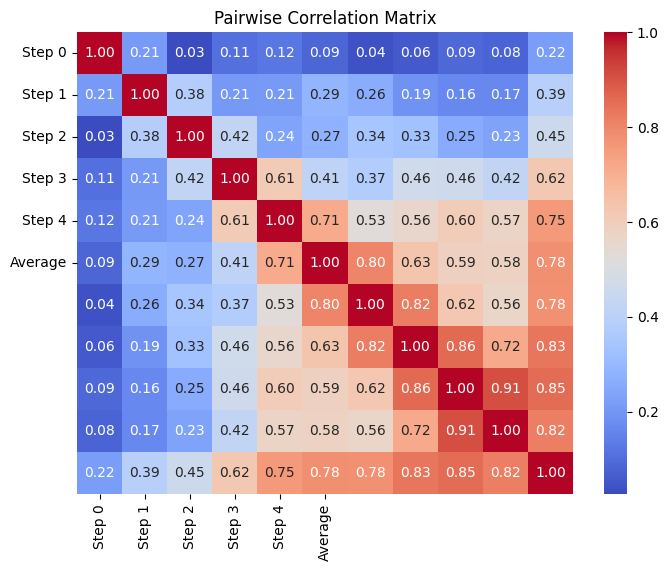

In [6]:

model_resp_steps = []
d_prime_steps = []
d_prime_dict = {}

for key, value in outputs.items():
    model_resp = outputs[key].transpose()
    #model_resp = model_resp[np.where(np.mean(model_resp, axis=1))[0],:]
    #model_resp_steps.append(model_resp)
    d_prime = np.array(calc_dprime(model_resp))
    d_prime = np.nan_to_num(d_prime, nan=0)
    d_prime_steps.append(d_prime)
    d_prime_dict[key] = d_prime


correlation_matrix = np.corrcoef(d_prime_steps)

xticklabels=[f'Step {i}' for i in range(5)] + ['Average']
yticklabels=[f'Step {i}' for i in range(5)] + ['Average']

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            xticklabels=xticklabels,
            yticklabels=yticklabels)
plt.title('Pairwise Correlation Matrix')
plt.show()

Question: 

- Should the d-prime be calculated for the average neural response or for a give 
timestep (corresponding to a time-window)

- What if we do this for different time-windows and find out d-prime changes significantly. Does 
this mean that the unit is face selective in one time-window and not face-selective in another?

### plot activity of all units in response to all images 

In [7]:
# sampe the activit for the last timestep
model_resp = range_normalize(outputs['step 4'].transpose())
model_resp.shape

(2048, 1162)

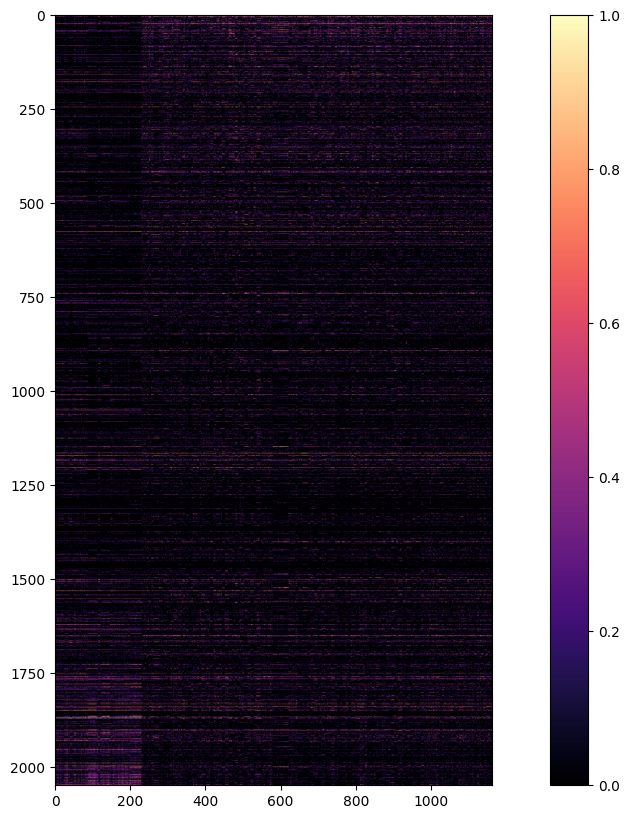

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
#plt.imshow(np.clip(model_resp, -5 , 5), cmap='magma')
d_prime = d_prime_steps[-2]
inds = np.argsort(d_prime) 

# order the units by face dprime
plt.imshow(model_resp[inds,:], cmap='magma')
plt.colorbar()
#plt.savefig('IT_response.png')

objects that have a high correlation with face dprime


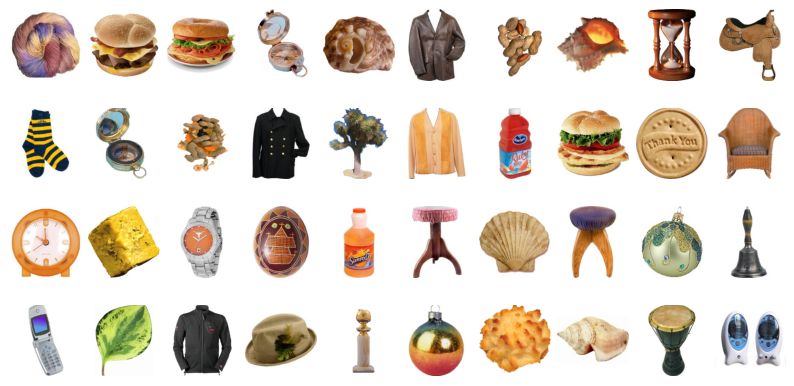

objects that have a low correlation with face dprime


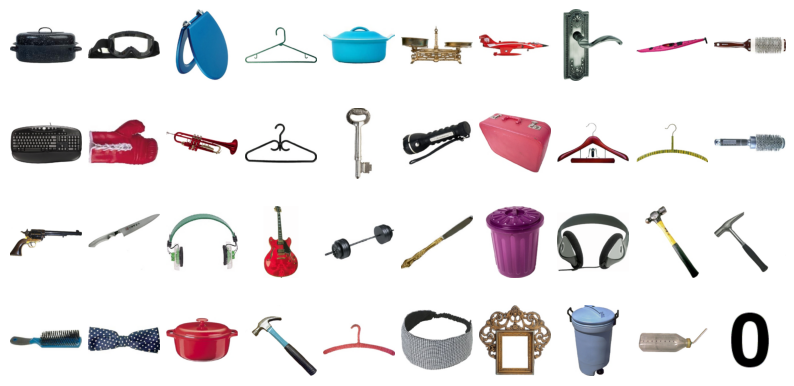

In [9]:

model_resp = range_normalize(outputs['step 9'].transpose())

# calculate the correlation between the model responses and d_prime
all_corrs = []
for im_ind in range(num_faces, imgs.shape[0]):
    
    corr_ = stats.pearsonr(model_resp[:,im_ind], d_prime)[0]
    all_corrs.append(corr_)

all_corrs = np.array(all_corrs)

all_corrs_inds = np.argsort(all_corrs)
# all_corrs = all_corrs[all_corrs_inds]

all_corrs_inds = all_corrs_inds + num_faces

top_n = 40

print('objects that have a high correlation with face dprime')

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(4, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(0,top_n):
    img = imgs[all_corrs_inds[-(i+1)]]
    ax = plt.subplot(gs[i//10,i % 10])
    ax.imshow(denormalize(img))
    ax.axis("off")

plt.show()

print('objects that have a low correlation with face dprime')

fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(4, 10)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(top_n):
    img = imgs[all_corrs_inds[i]]
    ax = plt.subplot(gs[i//10,i % 10])
    ax.imshow(denormalize(img))
    ax.axis("off")

plt.show()

In [10]:
def plot_dim_red(features, labels=None, transformer='MDS', save=None, add_text=True, add_bar=True):

    return_layers = list(features.keys())    

    fig = plt.figure(figsize=(3*len(return_layers), 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(return_layers))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    if add_text:
        fig.text(0.55, 0.95, transformer, size=14, ha="center")

    for l in range(len(return_layers)):
        layer =  return_layers[l]
        feats = features[layer]

        ax = plt.subplot(gs[0,l])
        ax.set_aspect('equal', adjustable='box')

        amin, amax = feats.min(), feats.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])
        
        # for d in range(2):
        #     feats[:, d] = feats[:, d] / (np.max(feats[:, d]) - np.mean(feats[:, d]))
        # ax.set_ylim(-1.3, 1.3)
        # ax.set_xlim(-1.3, 1.3)
        if add_text:
            ax.text(0.5, 1.1, f'{layer}', size=12, ha="center", transform=ax.transAxes) 
        ax.axis("off")
        #if l == 0: 
        # these lines are to create a discrete color bar
        # if labels is None:
        #     labels = np.zeros(len(feats[:, 0]))

        # num_colors = len(np.unique(labels))
        # cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
        # norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N) 
        ax_ = ax.scatter(feats[:, 1], feats[:, 0], c=labels, cmap='viridis_r', s=3)
    
    
    if add_bar:
        fig.subplots_adjust(right=0.9, top=0.9)
        cbar_ax = fig.add_axes([0.95, 0.3, 0.01, 0.45])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))

    # if save:
    #     fig.savefig(f'{save}.svg', format='svg', dpi=300, bbox_inches='tight')

    return fig


RDMs for responses for all the units in each time step


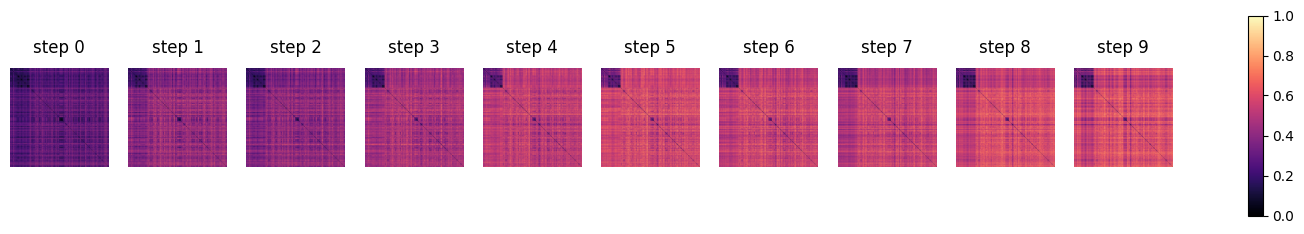

RDMs for responses for all the units with high face selectivity in each time step


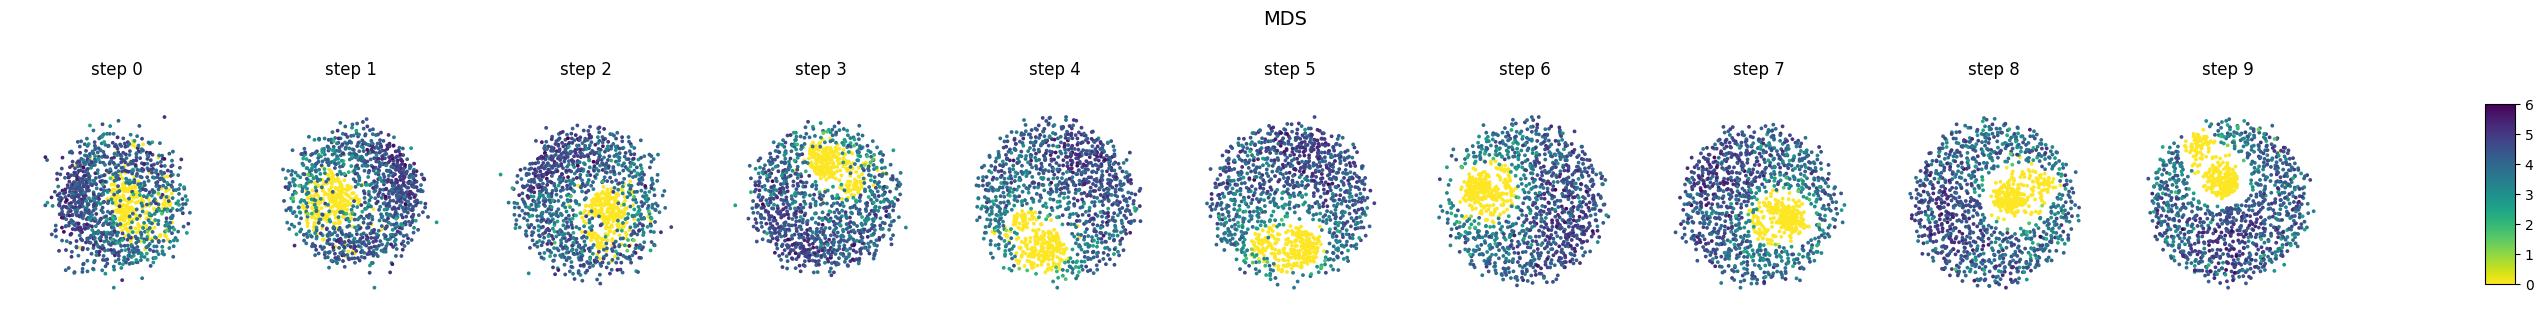

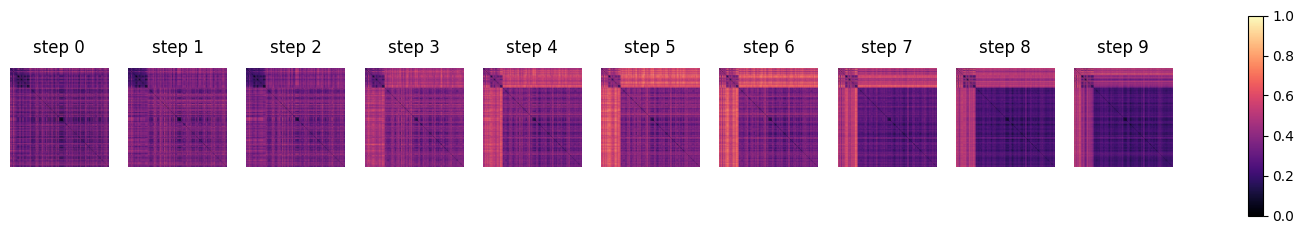

MDS plots for responses for all the units with high face selectivity in each time step


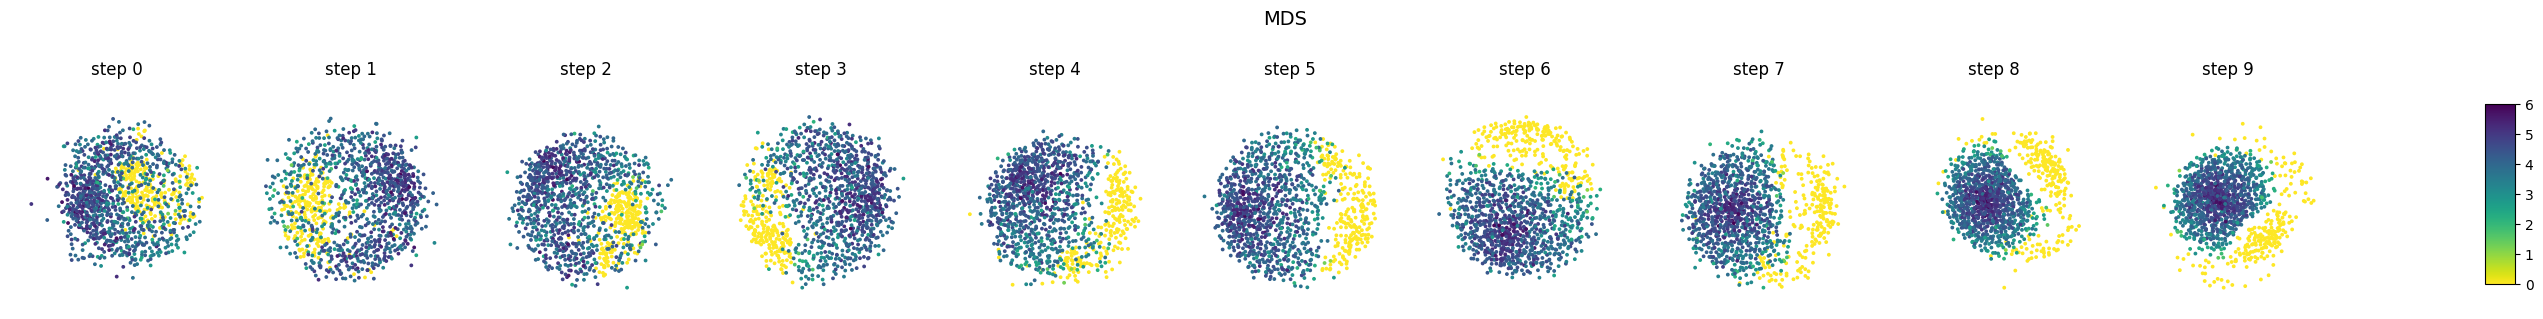

In [11]:
print('RDMs for responses for all the units in each time step')

features = {}
for key, value in outputs.items():
    if 'step' not in key:
        continue

    feats = outputs[key]

    d_prime = d_prime_dict[key]

    # inds = np.argsort(-all_corrs)  
    # inds = np.concatenate((np.arange(num_faces), all_corrs_inds))
    features[key]  = feats #[inds,:]

_, rdms_dict = calc_rdms(features)
fig = plot_maps(rdms_dict)
plt.show()


features_transformed = reduce_dim(features)
d_prime_corr_labels = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))
fig = plot_dim_red(features_transformed, d_prime_corr_labels)

print('RDMs for responses for all the units with high face selectivity in each time step')

features = {}
for key, value in outputs.items():
    if 'step' not in key:
        continue

    feats = outputs[key]

    d_prime = d_prime_dict[key]
    feats = feats[:,np.where(d_prime>0.2)[0]]

    # inds = np.argsort(-all_corrs)  
    # inds = np.concatenate((np.arange(num_faces), all_corrs_inds))
    features[key]  = feats #[inds,:]

_, rdms_dict = calc_rdms(features)
fig = plot_maps(rdms_dict)
plt.show()

print('MDS plots for responses for all the units with high face selectivity in each time step')

# d_prime_corr_labels = labels.copy()
# corr_labels =  (10*(all_corrs[230:]-np.min(all_corrs[230:]))).astype(int)
# corr_labels = 1 + (np.max(corr_labels) - corr_labels)
# d_prime_corr_labels[230:] = corr_labels
features_transformed = reduce_dim(features)
d_prime_corr_labels = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))
fig = plot_dim_red(features_transformed, d_prime_corr_labels)

AlexNet features

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet.to(device) # send the model to the chosen device ('cpu' or 'cuda')
alexnet.eval()
print(alexnet)
train_nodes, _ = get_graph_node_names(alexnet)
print(train_nodes)
model_layer = 'classifier.1'
feature_extractor = create_feature_extractor(alexnet, return_nodes=[model_layer])

# TODO grayscale or color images in this case? 
# it appears that the faces are differen from each other in this dataset and do not nicely
# cluster in the alexnet feature space. Making them grayscale helps. 
alexnet_feats = feature_extractor(imgs_gray.to(device))

fc6 = alexnet_feats[model_layer].cpu().detach().numpy()
#TODO should I z-score the activations?
fc6 = stats.zscore(fc6, axis=1)
fc6.shape

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/boranw/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/boranw/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:05<00:00, 43.5MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

(1162, 4096)

Extract AlexNet fc6 features from the same experimental images 

Questions:

- Should the images that we use to create this representational bases be different than the experimental images? 

- Which one of these to pick? They all have 4096 dimensions:

    (1): Linear(in_features=9216, out_features=4096, bias=True)

    (2): ReLU(inplace=True)

    (3): Dropout(p=0.5, inplace=False)

    (4): Linear(in_features=4096, out_features=4096, bias=True)

    (5): ReLU(inplace=True)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60, svd_solver='arpack')
feats_transformed = pca.fit_transform(fc6)

axis = 1  # For example, axis 0 for columns

# Calculate the mean and standard deviation along the specified axis
axis_mean = np.mean(feats_transformed, axis=axis, keepdims=True)
axis_std_dev = np.std(feats_transformed, axis=axis, keepdims=True)

# Standardize the data
standardized_data = (feats_transformed - axis_mean) / axis_std_dev

feats_transformed = {}
feats_transformed['fc6'] = standardized_data

Use PCA to reduce the dimension to 60

And then standardize the data along each PC? 

In [14]:
import matplotlib as mpl

def plot_pcs(features, labels=None, transformer='MDS', save=None, add_text=True, add_bar=True, color_map='viridis_r'):

    return_layers = list(features.keys())    

    fig = plt.figure(figsize=(3*len(return_layers), 4))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(return_layers))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    if add_text:
        fig.text(0.55, 0.95, transformer, size=14, ha="center")

    for l in range(len(return_layers)):
        layer =  return_layers[l]
        feats = features[layer]

        lablels_l = labels[layer]

        ax = plt.subplot(gs[0,l])
        ax.set_aspect('equal', adjustable='box')

        amin, amax = feats.min(), feats.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])
        
        # for d in range(2):
        #     feats[:, d] = feats[:, d] / (np.max(feats[:, d]) - np.mean(feats[:, d]))
        # ax.set_ylim(-1.3, 1.3)
        # ax.set_xlim(-1.3, 1.3)
        if add_text:
            ax.text(0.5, 1.1, f'{layer}', size=12, ha="center", transform=ax.transAxes) 
        #ax.axis("off")
        #if l == 0: 
        # these lines are to create a discrete color bar
        # if labels is None:
        #     lablels_l = np.zeros(len(feats[:, 0]))

        # num_colors = len(np.unique(lablels_l))
        # cmap = plt.get_cmap(color_map, num_colors) # 10 discrete colors
        # norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)  # norm=norm,
        ax_ = ax.scatter(feats[:, 0], -feats[:, 1], c=lablels_l, cmap=color_map, s=3)

        ax.set_xlim([-8, 8])
        ax.set_ylim([-8, 8])
    
    
    if add_bar:
        fig.subplots_adjust(right=0.9, top=0.9)
        cbar_ax = fig.add_axes([0.95, 0.3, 0.01, 0.45])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))

    # if save:
    #     fig.savefig(f'{save}.svg', format='svg', dpi=300, bbox_inches='tight')

    return fig

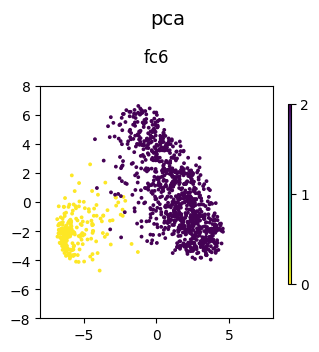

In [15]:
labels_dict = {}
labels_dict['fc6'] = labels
fig = plot_pcs(feats_transformed, labels_dict, transformer='pca')

In [16]:
model_resp_steps = []
for key, value in outputs.items():
    if 'step' in key:
        model_resp_steps.append(outputs[key].transpose())

model_resp_steps = np.array(model_resp_steps)

threshold = 0.2
#  TODO which step should be used for dprime to select face cells
d_prime = d_prime_steps[-1]
face_cell_inds = np.where(d_prime > threshold)[0]
face_cell_resp_steps = model_resp_steps[:,face_cell_inds, :] 

# max_vals = face_cell_resp_steps.max(axis=0, keepdims=True)
# Normalize each row
# face_cell_resp_steps = face_cell_resp_steps / max_vals
# face_cell_resp_steps = stats.zscore(face_cell_resp_steps, axis=1)
# face_cell_resp_steps = stats.zscore(face_cell_resp_steps, axis=0)

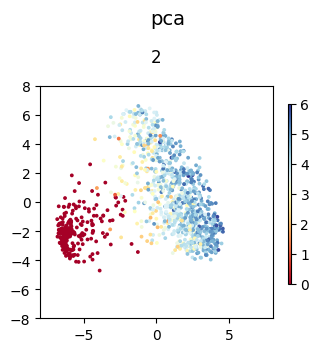

In [17]:
from sklearn.preprocessing import KBinsDiscretizer

labels_dict = {}
feat_objects = {}

for step in[2]: # range(len(face_cell_resp_steps)-1):

    feat_objects[str(step)] = feats_transformed['fc6']

    unit_response = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs)))

    labels_dict[str(step)] = unit_response


fig = plot_pcs(feat_objects, labels_dict, transformer='pca', color_map='RdYlBu')

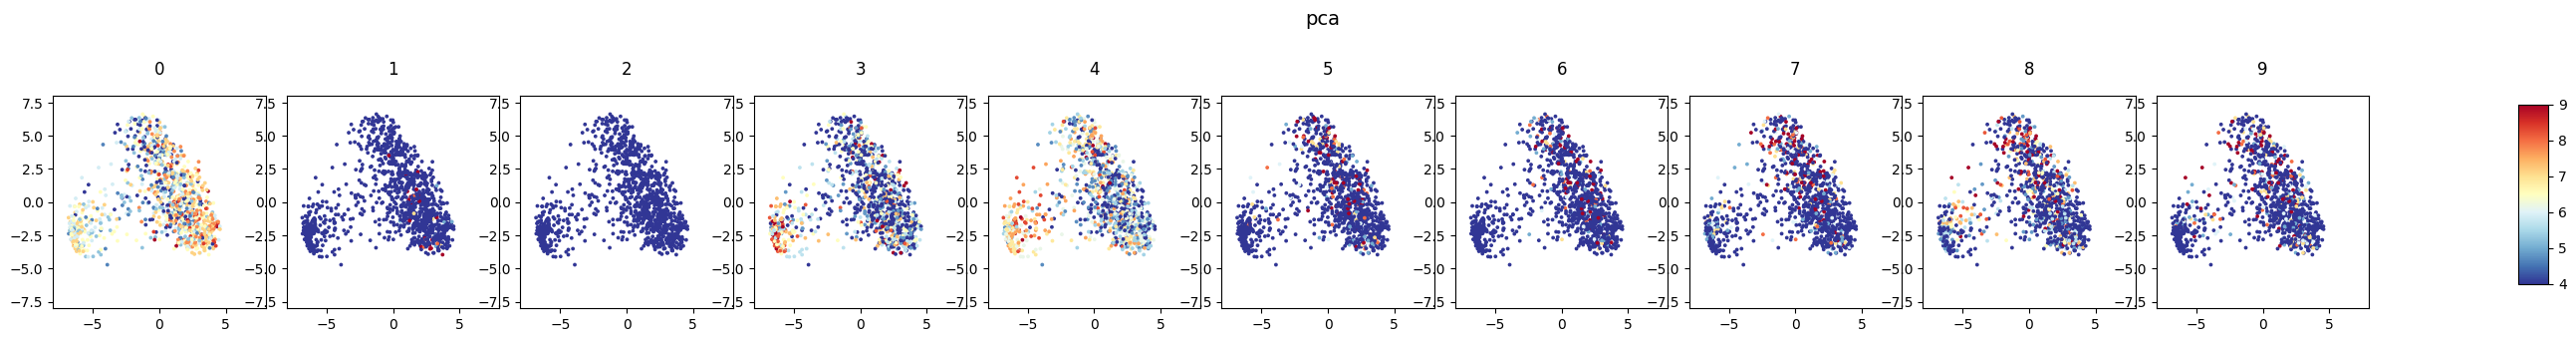

In [18]:
from sklearn.preprocessing import KBinsDiscretizer

unit = 20
#unit_response = face_cell_resp_steps.mean(axis=0)[unit].reshape(-1, 1)
labels_dict = {}
feat_objects = {}

start = -2
end = 2 # 2.2
# Create bins with a step size of 0.2
step_size = 0.5 # 0.2
bins = np.arange(start, end + step_size, step_size)

for step in range(len(face_cell_resp_steps)):

    feat_objects[str(step)] = feats_transformed['fc6']

    unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)

    # so we can use the same scale for all the time-steps
    unit_response = stats.zscore(unit_response, axis=0)

    # Discretize the array using the defined bins
    discretized = np.digitize(unit_response, bins)

    labels_dict[str(step)] = discretized

fig = plot_pcs(feat_objects, labels_dict, transformer='pca', color_map='RdYlBu_r')

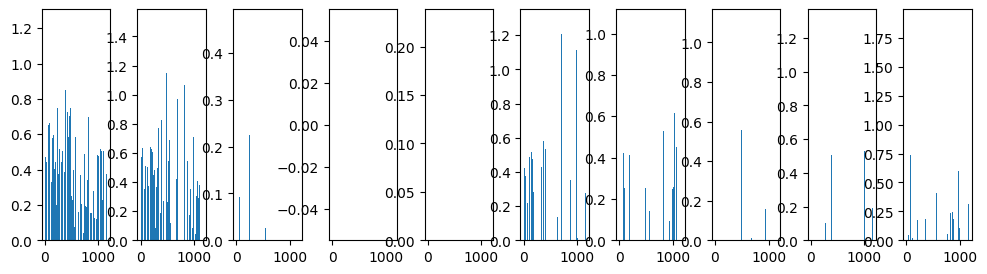

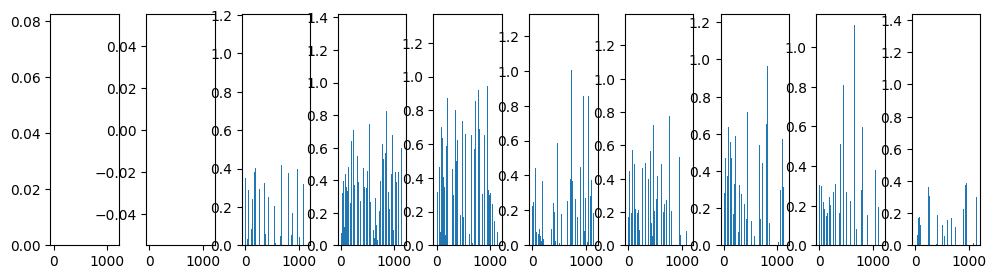

In [19]:
# look at the activity of some face-selective units for different images 
# across differrent time-steps
for unit in range(0, 2):

    fig = plt.figure(figsize=(12, 3))
    # and we add one plot per reference point
    gs = fig.add_gridspec(1, len(face_cell_resp_steps))
    fig.subplots_adjust(wspace=0.4, hspace=0.1)

    for step in range(len(face_cell_resp_steps)):

        ax = plt.subplot(gs[0,step])

        unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)
        unit_response = unit_response.squeeze()
        x = np.arange(len(unit_response))  # Creates an array [0, 1, 2, ..., len(data)-1]

        # Create the bar plot
        ax.bar(x, unit_response)
    plt.show()

Calcualate the prefered axes of the two clusters for each unit at each time step.

This means finding the axis in the 60d space of alexnet fc6 representation than captures the most variance in responses of the different objects (respose gradient direction). 

[0.0405334  0.06260463 0.06103539 0.08760924 0.11082047 0.12434816
 0.11755476 0.11812    0.12104314 0.10140245]


Text(0, 0.5, 'correlation')

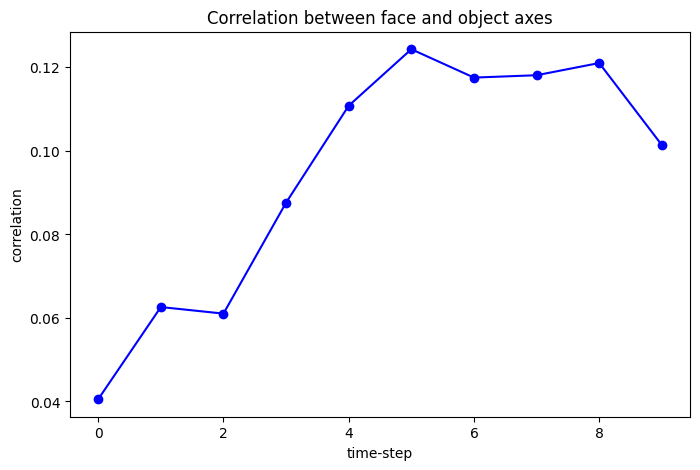

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_preferred_axis(r, F):
    """
    Compute the preferred axis of each cell using linear regression.

    Parameters:
    - r: 1D numpy array of firing rates (n,)
    - F: 2D numpy array of feature matrix (n x d)

    Returns:
    - P_lin: 1D numpy array of the preferred axis (d,)
    """
    # Compute mean firing rate
    mean_firing_rate = np.mean(r)

    # Center the firing rate vector by subtracting the mean firing rate
    r_centered = r - mean_firing_rate

    # Compute the inverse of (F^T F)
    # TODO: make the inv operation closer to deterministic, if possbile, given small values in data
    FtF = np.dot(F.T, F)
    FtF_inv = np.linalg.inv(FtF)

    # Compute the preferred axis
    P_lin = np.dot(np.dot(r_centered, F), FtF_inv)

    return P_lin


p_lin_faces_all = np.zeros((*face_cell_resp_steps.shape[0:2], feats_transformed['fc6'].shape[1]))
p_lin_nonfaces_all = np.zeros((*face_cell_resp_steps.shape[0:2], feats_transformed['fc6'].shape[1]))
face_nonface_sim = np.zeros((face_cell_resp_steps.shape[0], face_cell_resp_steps.shape[1]))

for step in range(0,len(face_cell_resp_steps)):
    for unit in range(face_cell_resp_steps.shape[1]):

        unit_response = face_cell_resp_steps[step][unit].reshape(-1, 1)

        unit_response_to_faces = unit_response[labels==0].transpose()
        unit_response_to_nonfaces = unit_response[labels!=0].transpose()

        fc6_pca_faces = feats_transformed['fc6'][labels==0]
        fc6_pca_nonfaces = feats_transformed['fc6'][labels!=0]

        p_lin_nonfaces = compute_preferred_axis(unit_response_to_nonfaces, fc6_pca_nonfaces)
        p_lin_nonfaces_all[step, unit] = p_lin_nonfaces

        p_lin_faces = compute_preferred_axis(unit_response_to_faces, fc6_pca_faces)
        p_lin_faces_all[step, unit] = p_lin_faces

        sim = stats.pearsonr(p_lin_faces.squeeze(), p_lin_nonfaces.squeeze())[0]
        #print(stats.pearsonr(p_lin_faces.squeeze(), p_lin_nonfaces.squeeze()))
        #sim = cosine_similarity(p_lin_faces, p_lin_nonfaces)
        #print(cosine_similarity(p_lin_faces, p_lin_nonfaces))

        face_nonface_sim[step, unit] = sim
        
#TODO remove the nans
axes_sim = np.mean(np.nan_to_num(face_nonface_sim), axis=1)
print(axes_sim)

plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(axes_sim)), axes_sim, marker='o', linestyle='-', color='b')  # Plot points and connect them
plt.title('Correlation between face and object axes')
plt.xlabel('time-step')
plt.ylabel('correlation')

Does the normalization explain the lower response later? 

Are you z-scoring across time? 

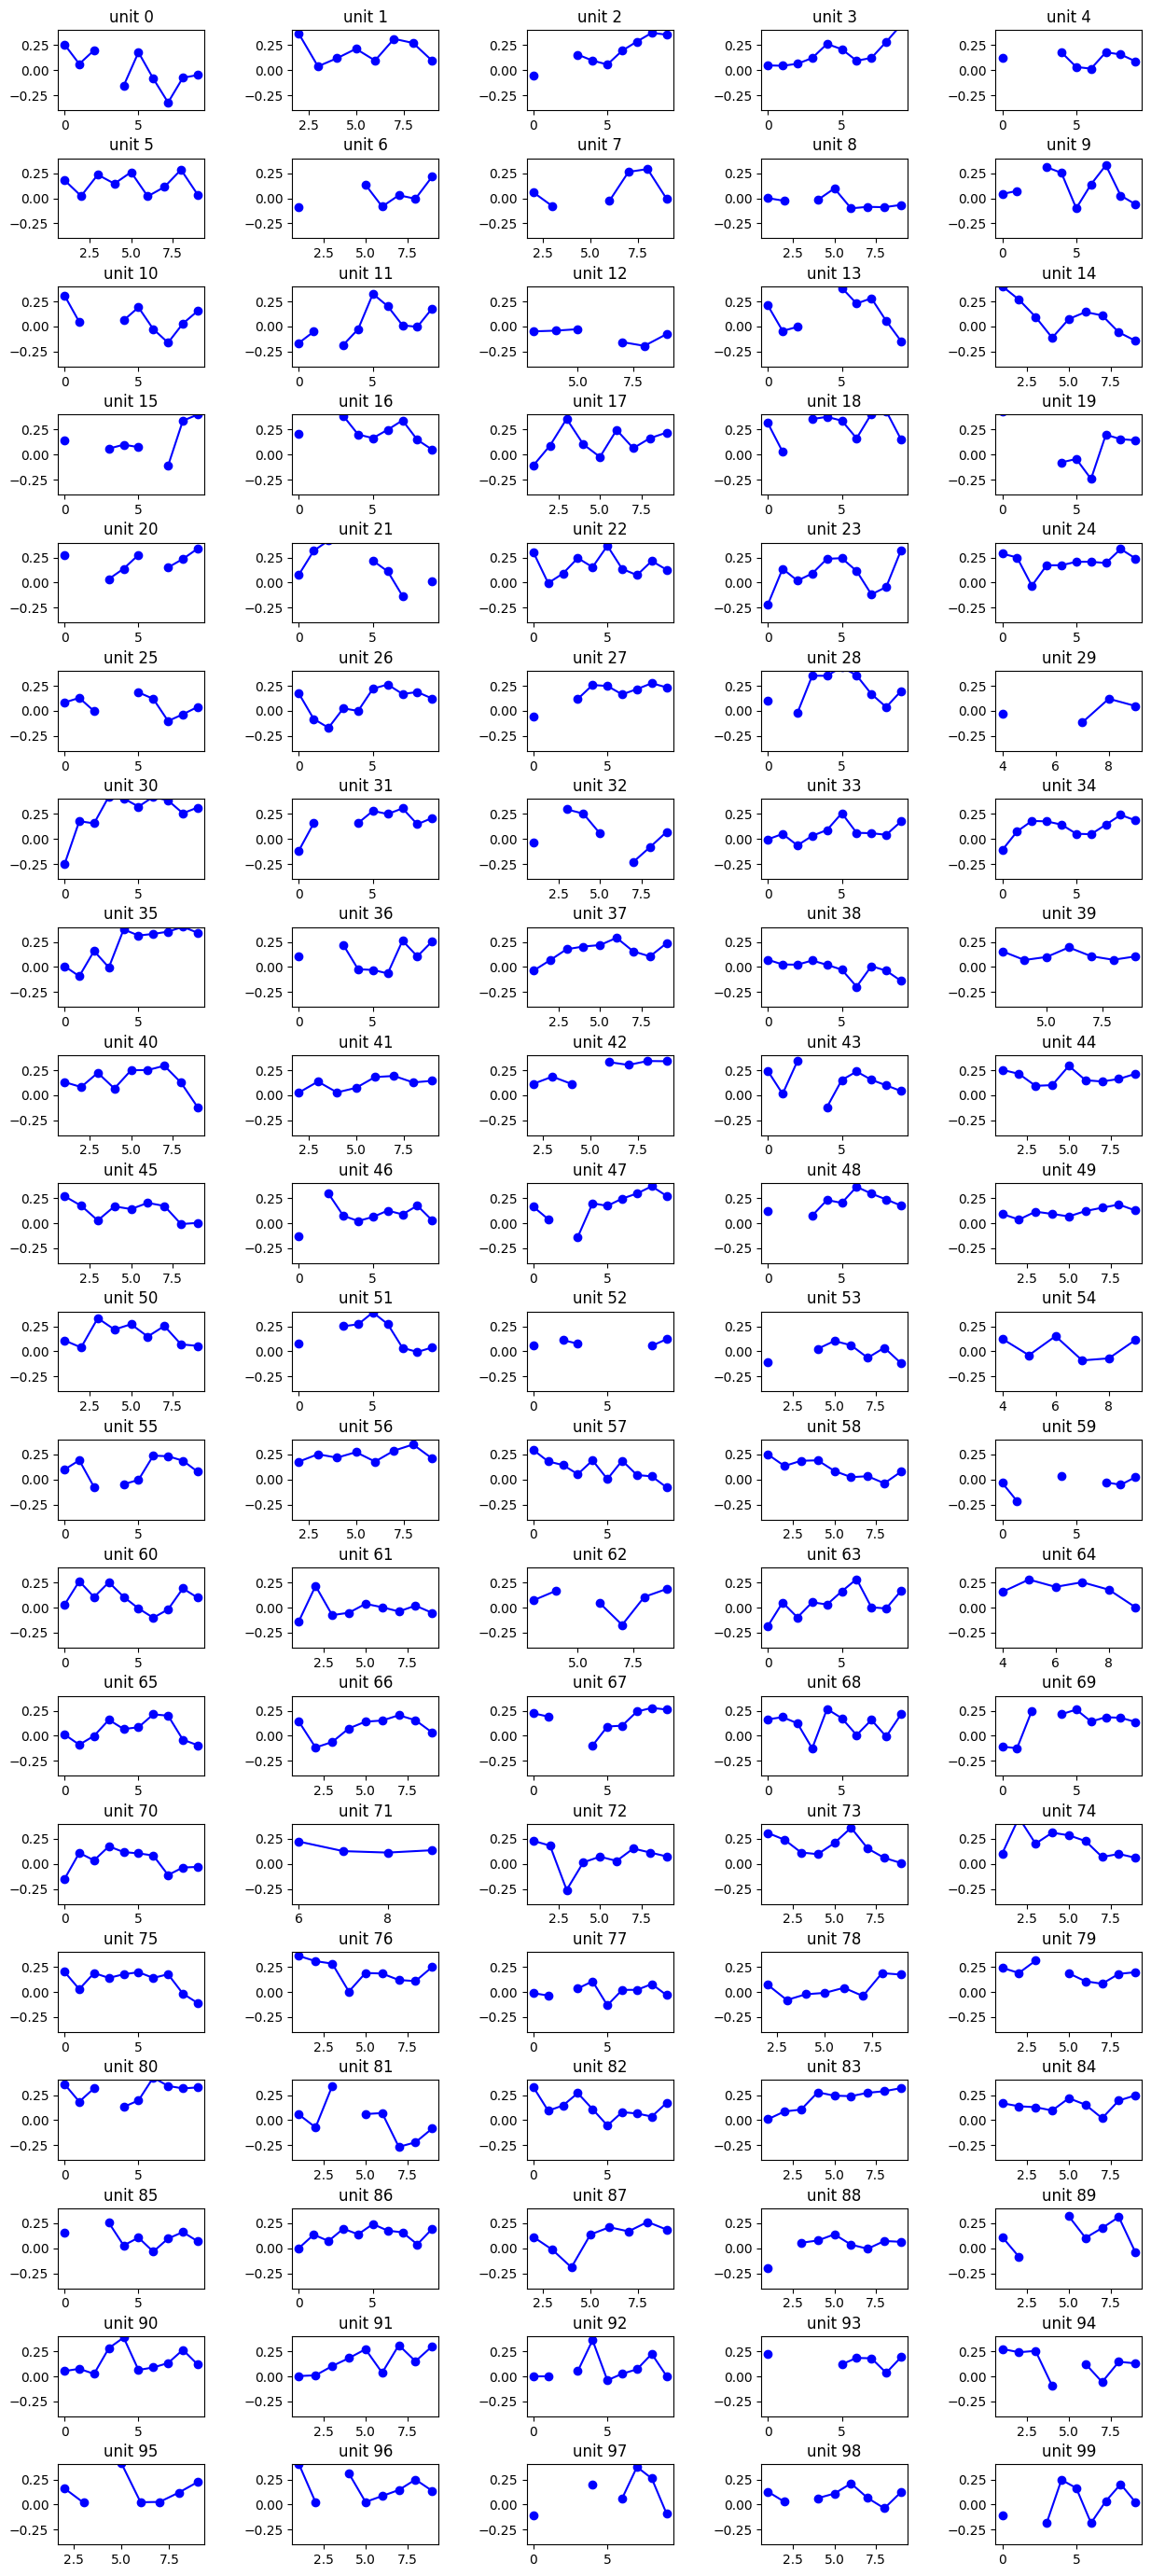

In [21]:
fig = plt.figure(figsize=(15, 35))
# and we add one plot per reference point
r, c = 20, 5
gs = fig.add_gridspec(r, c)
fig.subplots_adjust(wspace=0.6, hspace=0.6)

for u in range(r): #face_nonface_sim.shape[1]):
    for v in range(c): #face_nonface_sim.shape[1]):
        unit = u*c + v
        ax = plt.subplot(gs[u,v])
        ax.plot(np.arange(len(axes_sim)), face_nonface_sim[:,unit], marker='o', linestyle='-', color='b') 

        #ax.set_xlim([amin, amax])
        ax.set_ylim([-0.4, 0.4])
        ax.set_title(f'unit {unit}')
plt.show() # Plot points and connect them


### Compare the neuro-data rdms to model rdms across steps

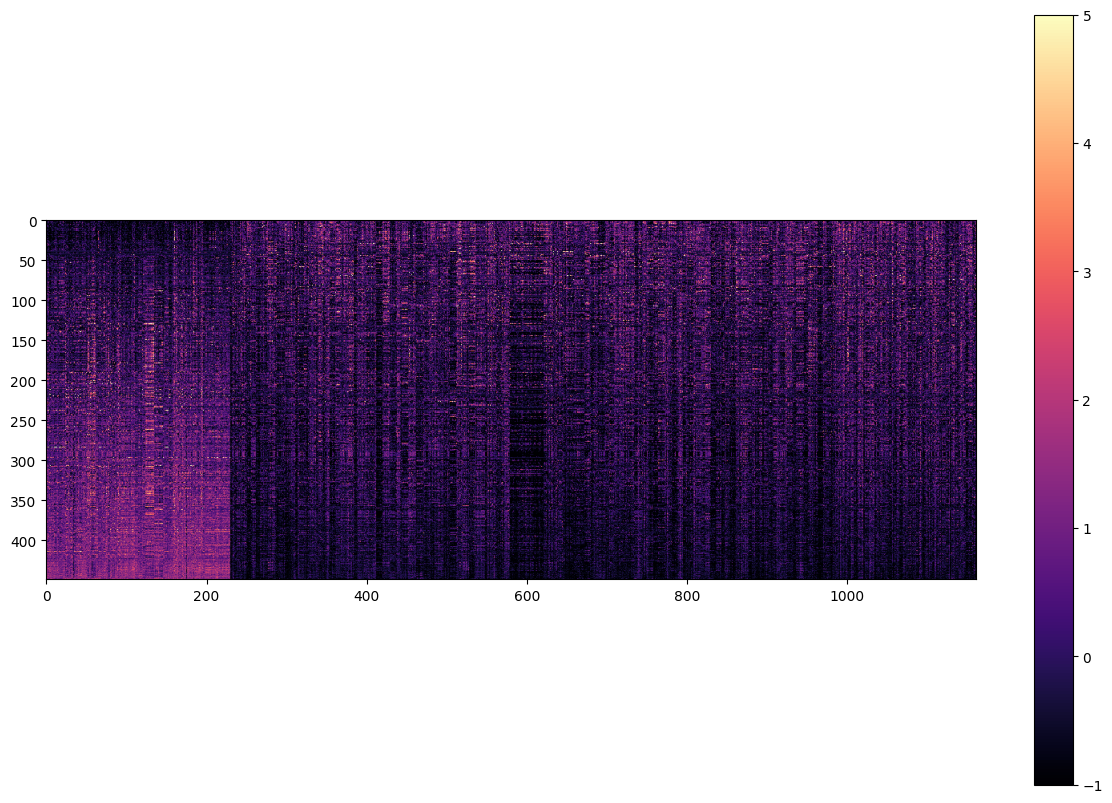

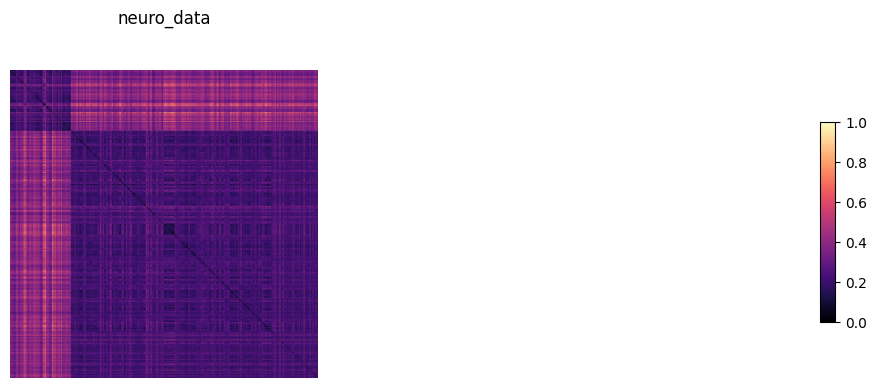

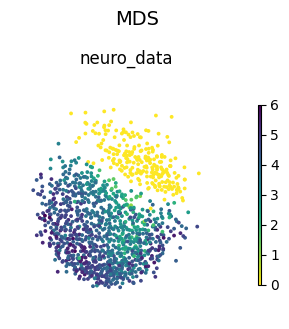

In [22]:
# first plot the neurdata rdm

#neuro_data = (neuro_data - np.mean(neuro_data[num_faces:])) / np.std(neuro_data[num_faces:])
neuro_data = np.clip(neuro_data, a_max=5, a_min=-1)
neuro_data_dict = {'neuro_data':neuro_data}
#neuro_data_dict = {'neuro_data':neuro_data}

d_prime_neuro = calc_dprime(neuro_data.transpose())
fig, ax = plt.subplots(figsize=(15, 10))
#plt.imshow(np.clip(model_resp, -5 , 5), cmap='magma')
inds = np.argsort(d_prime_neuro)
#plt.imshow(neuro_data.transpose()[inds,:], cmap='magma')
plt.imshow(np.clip(neuro_data.transpose()[inds,:], a_max=5, a_min=-1), cmap='magma')
plt.colorbar()
plt.savefig('IT_response.png')

neuro_rdms, neuro_rdms_dict = calc_rdms(neuro_data_dict)
fig = plot_maps(neuro_rdms_dict)


all_corrs_neuro = []
for im_ind in range(num_faces, imgs.shape[0]):
    
    corr_ = stats.pearsonr(neuro_data[im_ind,:], d_prime_neuro)[0]
    all_corrs_neuro.append(corr_)

all_corrs_neuro = np.array(all_corrs_neuro)

features_transformed = reduce_dim({'neuro_data':neuro_data}) 
#fig = plot_dim_red(features_transformed, d_prime_corr_labels)
d_prime_corr_labels = np.concatenate((np.zeros(num_faces), 1+5*range_normalize(-all_corrs_neuro)))

fig = plot_dim_red(features_transformed, d_prime_corr_labels)

Was the neurodata clipped to be between -1 and 5 after z-scoring in figure 1 of the paper? Becuase the acutal range is outside of that

In [23]:
#TODO should d_prime be calculated for each time-step or for the average response?
features = {}
for key, value in outputs.items():
    if 'step' not in key:
        continue

    feats = outputs[key]

    d_prime = d_prime_dict[key] # d_prime_dict['average'] # 
    feats = feats[:,np.where(d_prime>0.2)[0]]

    # inds = np.argsort(-all_corrs)  
    # inds = np.concatenate((np.arange(num_faces), all_corrs_inds))
    features[key]  = feats #[inds,:]


# add alexnet to the mix
features['alexnet_fc6'] = fc6 

model_rdms, rdms_dict = calc_rdms(features)
# fig = plot_maps(rdms_dict)
# plt.show()

pred_models = []
pred_model_names = []
layer = 'output_5'
for model_name in list(rdms_dict.keys()):
    rdm_m = model_rdms.subset('layer', model_name)
    m = rsatoolbox.model.ModelFixed(f'{layer} {model_name}', rdm_m)
    pred_model_names.append(f'{layer} {model_name}')
    pred_models.append(m)

100%|██████████| 20/20 [00:04<00:00,  4.23it/s]

Results for running bootstrap_pattern evaluation for corr on 11 models:

Model                |   Eval ± SEM   | p (against 0) | p (against NC) |
------------------------------------------------------------------------
output_5 step 0      |  0.031 ± 0.016 |        0.027  |       < 0.001  |
output_5 step 1      |  0.109 ± 0.014 |      < 0.001  |       < 0.001  |
output_5 step 2      |  0.163 ± 0.018 |      < 0.001  |       < 0.001  |
output_5 step 3      |  0.405 ± 0.021 |      < 0.001  |       < 0.001  |
output_5 step 4      |  0.567 ± 0.016 |      < 0.001  |       < 0.001  |
output_5 step 5      |  0.608 ± 0.017 |      < 0.001  |       < 0.001  |
output_5 step 6      |  0.573 ± 0.017 |      < 0.001  |       < 0.001  |
output_5 step 7      |  0.559 ± 0.012 |      < 0.001  |       < 0.001  |
output_5 step 8      |  0.584 ± 0.012 |      < 0.001  |       < 0.001  |
output_5 step 9      |  0.528 ± 0.015 |      < 0.001  |       < 0.001  |
output_5 alexnet_fc6 |  0.269 ± 0.012 |      < 0.00

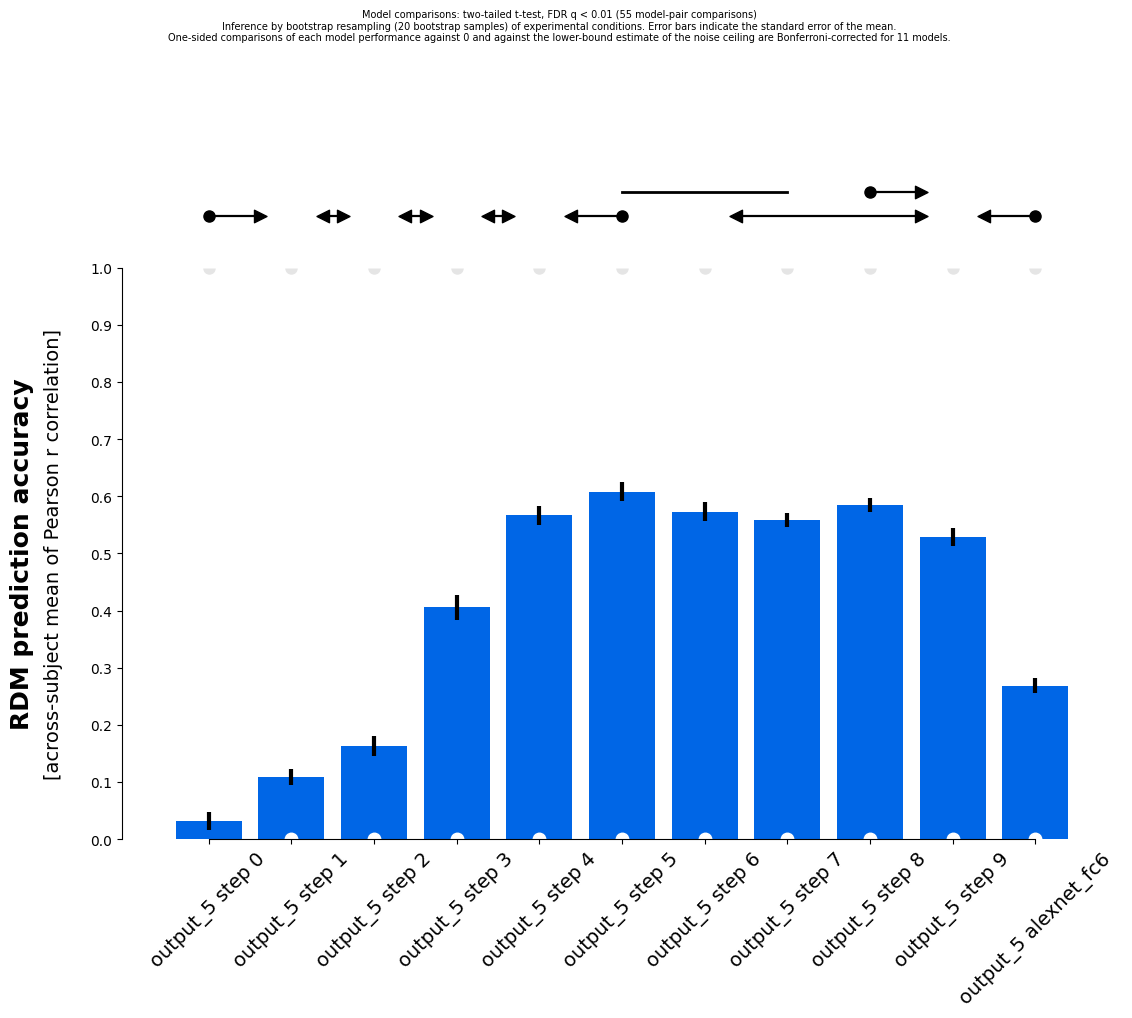

In [24]:
N=20
method='corr'
results = rsatoolbox.inference.eval_bootstrap_pattern(pred_models, neuro_rdms, method=method, N=N)
rsatoolbox.vis.plot_model_comparison(results)
# return results, pred_model_names
print(results)

Note that this is fixes rdm comparison. The paper (Vinken et al, 2023) learned encoding models from the model features from the feature models, then calculated RDMs based on the predictions. 

Can we predict the d_prime for units from responses only to non-faces? 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.metrics import r2_score

non_face_resp = outputs['step 4'].transpose() #model_resp_steps[-1, :, num_faces:]

X_train, X_test, y_train, y_test = train_test_split(non_face_resp, d_prime_dict['step 4'], test_size=0.2, random_state=42)

svm_reg = svm.SVR(kernel='linear').fit(X_train, y_train)
print('svm reg train: ', svm_reg.score(X_train, y_train))
print('svm reg test: ', svm_reg.score(X_test, y_test))
y_pred = svm_reg.predict(X_test) 

svm reg train:  0.968716444662845
svm reg test:  0.7104870046093003


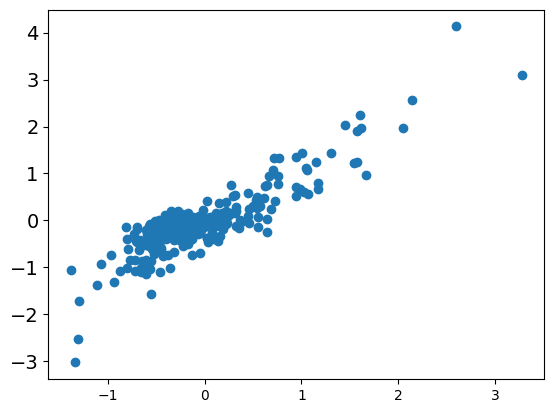

In [29]:
plt.scatter(y_test, y_pred)

Better ways of doing it all? 

Why alexnet-fc6? 



In [30]:
fc6_pca_faces.shape

(230, 60)

In [45]:
# @title Helper functions (Bonus Section)

import contextlib
import io
import argparse
# Standard library imports
from collections import OrderedDict
import logging

# External libraries: General utilities
import argparse
import numpy as np

# PyTorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, random_split
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.utils import make_grid


# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# SciPy for statistical functions
from scipy import stats

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# RSA toolbox specific imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

class Net(nn.Module):
    """
    A neural network model for image classification, consisting of two convolutional layers,
    followed by two fully connected layers with dropout regularization.

    Methods:
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self):
        """
        Initializes the network layers.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 32 output channels, and a 3x3 kernel.
        - conv2: Second convolutional layer with 32 input channels, 64 output channels, and a 3x3 kernel.
        - dropout1: Dropout layer with a dropout probability of 0.25.
        - dropout2: Dropout layer with a dropout probability of 0.5.
        - fc1: First fully connected layer with 9216 input features and 128 output features.
        - fc2: Second fully connected layer with 128 input features and 10 output features.
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

class recurrent_Net(nn.Module):
    """
    A recurrent neural network model for image classification, consisting of two convolutional layers
    with recurrent connections and a readout layer.

    Methods:
    - __init__(time_steps=5): Initializes the network layers and sets the number of time steps for recurrence.
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self, time_steps=5):
        """
        Initializes the network layers and sets the number of time steps for recurrence.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 16 output channels, and a 3x3 kernel with a stride of 3.
        - conv2: Second convolutional layer with 16 input channels, 16 output channels, and a 3x3 kernel with padding of 1.
        - readout: A sequential layer containing:
            - dropout: Dropout layer with a dropout probability of 0.25.
            - avgpool: Adaptive average pooling layer to reduce spatial dimensions to 1x1.
            - flatten: Flatten layer to convert the 2D pooled output to 1D.
            - linear: Fully connected layer with 16 input features and 10 output features.
        - time_steps (int): Number of time steps for the recurrent connection.
        """
        super(recurrent_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 3)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.readout = nn.Sequential(OrderedDict([
            ('dropout', nn.Dropout(0.25)),
            ('avgpool', nn.AdaptiveAvgPool2d(1)),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(16, 10))
        ]))
        self.time_steps = time_steps

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        input = self.conv1(input)
        x = input
        for t in range(0, self.time_steps):
            x = input + self.conv2(x)
            x = F.relu(x)

        x = self.readout(x)
        output = F.softmax(x, dim=1)
        return output


def train_one_epoch(args, model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch.

    Inputs:
    - args (Namespace): Arguments for training configuration.
    - model (torch.nn.Module): The model to be trained.
    - device (torch.device): The device to use for training (CPU/GPU).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epoch (int): The current epoch number.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = torch.log(output)  # to make it a log_softmax
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader, return_features=False):
    """
    Evaluates the model on the test dataset.

    Inputs:
    - model (torch.nn.Module): The model to be evaluated.
    - device (torch.device): The device to use for evaluation (CPU/GPU).
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    - return_features (bool): If True, returns the features from the model. Default is False.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = torch.log(output)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def build_args():
    """
    Builds and parses command-line arguments for training.
    """
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

def fetch_dataloaders(args):
    """
    Fetches the data loaders for training and testing datasets.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.

    Outputs:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    """
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    with contextlib.redirect_stdout(io.StringIO()): #to suppress output
        dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
        dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
        train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        return train_loader, test_loader
    
def kasper_loaders(args):

    imgs, labels, neuro_data = kasper_dataset()

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}

    if not torch.is_tensor(imgs):
        imgs = torch.as_tensor(imgs)
    imgs = imgs.float()

    if isinstance(labels, np.ndarray):
        labels = torch.from_numpy(labels)
    elif not torch.is_tensor(labels):
        labels = torch.as_tensor(labels)
    labels = labels.long()

    if isinstance(neuro_data, np.ndarray):
        neuro_data = torch.from_numpy(neuro_data)
    elif not torch.is_tensor(neuro_data):
        neuro_data = torch.as_tensor(neuro_data)
    neuro_data = neuro_data.float()

    imgs_gray = torchvision.transforms.functional.rgb_to_grayscale(imgs, num_output_channels=3)

    mask = labels != 1
    imgs_gray = imgs_gray[mask]
    imgs = imgs[mask]
    labels = labels[mask]
    neuro_data = neuro_data[mask]

    num_faces = int((labels == 0).sum().item())
    setattr(args, "num_faces", num_faces)

    dataset = TensorDataset(imgs_gray, labels, neuro_data)

    dataset_fraction = float(getattr(args, "train_split", 0.8))
    dataset_fraction = min(max(dataset_fraction, 0.0), 1.0)

    total_items = len(dataset)
    train_size = int(round(total_items * dataset_fraction))
    train_size = min(max(train_size, 1), total_items - 1)
    test_size = total_items - train_size

    seed = getattr(args, "seed", None)
    generator = torch.Generator()
    if seed is not None:
        generator.manual_seed(seed)

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

    train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)
    return train_loader, test_loader

def train_model(args, model, optimizer):
    """
    Trains the model using the specified arguments and optimizer.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.

    Outputs:
    - None: The function trains the model and optionally saves it.
    """
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        if args.use_cuda:
            feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []

    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        output = torch.log(output)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    output = torch.log(output)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    if return_layers == 'all':
        return_layers, _ = get_graph_node_names(model)
    elif return_layers == 'layers':
        layers, _ = get_graph_node_names(model)
        return_layers = [l for l in layers if 'input' in l or 'conv' in l or 'fc' in l]

    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    return model_features

# @title Plotting functions (Bonus)

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outputs:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """

    with plt.xkcd():
        imgs, targets = next(iter(data_loader))

        imgs_o = []
        labels = []
        for value in range(10):
            cat_imgs = imgs[np.where(targets == value)][0:n]
            imgs_o.append(cat_imgs)
            labels.append([value]*len(cat_imgs))

        imgs = torch.cat(imgs_o, dim=0)
        labels = torch.tensor(labels).flatten()

        if plot:
            plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
            plt.axis('off')

        return imgs, labels


def plot_rdms(model_rdms):
    """
    Plots the Representational Dissimilarity Matrices (RDMs) for each layer of a model.

    Inputs:
    - model_rdms (dict): A dictionary where keys are layer names and values are the corresponding RDMs.
    """

    with plt.xkcd():
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, len(model_rdms))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_rdms)):

            layer = list(model_rdms.keys())[l]
            rdm = np.squeeze(model_rdms[layer])

            if len(rdm.shape) < 2:
                rdm = rdm.reshape( (int(np.sqrt(rdm.shape[0])), int(np.sqrt(rdm.shape[0]))) )

            rdm = rdm / np.max(rdm)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(rdm, cmap='magma_r')
            ax.set_title(f'{layer}')

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar_ax.text(-2.3, 0.05, 'Normalized euclidean distance', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax)

        plt.show()

def rep_path(model_features, model_colors, labels=None, rdm_calc_method='euclidean', rdm_comp_method='cosine'):
    """
    Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features (dict): Dictionary containing model features for each model.
    - model_colors (dict): Dictionary mapping model names to colors for visualization.
    - labels (array-like, optional): Array of labels corresponding to the model features.
    - rdm_calc_method (str, optional): Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method (str, optional): Method for comparing RDMS ('cosine' or 'corr').
    """
    with plt.xkcd():
        path_len = []
        path_colors = []
        rdms_list = []
        ax_ticks = []
        tick_colors = []
        model_names = list(model_features.keys())
        for m in range(len(model_names)):
            model_name = model_names[m]
            features = model_features[model_name]
            path_colors.append(model_colors[model_name])
            path_len.append(len(features))
            ax_ticks.append(list(features.keys()))
            tick_colors.append([model_colors[model_name]]*len(features))
            rdms, _ = calc_rdms(features, method=rdm_calc_method)
            rdms_list.append(rdms)

        path_len = np.insert(np.cumsum(path_len),0,0)

        if labels is not None:
            rdms, _ = calc_rdms({'labels' : F.one_hot(labels).float().to(device)}, method=rdm_calc_method)
            rdms_list.append(rdms)
            ax_ticks.append(['labels'])
            tick_colors.append(['m'])
            idx_labels = -1

        rdms = rsatoolbox.rdm.concat(rdms_list)

        #Flatten the list
        ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
        tick_colors = [l for model_layers in tick_colors for l in model_layers]
        tick_colors = ['k' if tick == 'input' else color for tick, color in zip(ax_ticks, tick_colors)]

        rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
        if rdm_comp_method == 'cosine':
            rdms_comp = np.arccos(rdms_comp)
        rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)

        # Symmetrize
        rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

        # reduce dim to 2
        transformer = manifold.MDS(n_components = 2, max_iter=1000, n_init=10, normalized_stress='auto', dissimilarity="precomputed")
        dims= transformer.fit_transform(rdms_comp)

        # remove duplicates of the input layer from multiple models
        remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
        for index in remove_duplicates:
            del ax_ticks[index]
            del tick_colors[index]
            rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 2)
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        ax = plt.subplot(gs[0,0])
        ax_ = ax.imshow(rdms_comp, cmap='viridis_r')
        fig.subplots_adjust(left=0.2)
        cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
        #cbar_ax.text(-7, 0.05, 'dissimilarity between rdms', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax,location='left')
        ax.set_title('Dissimilarity between layer rdms', fontdict = {'fontsize': 14})
        ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=83)
        ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

        ax = plt.subplot(gs[0,1])
        amin, amax = dims.min(), dims.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8

        for i in range(len(rdms_list)-1):

            path_indices = np.arange(path_len[i], path_len[i+1])
            ax.plot(dims[path_indices, 0], dims[path_indices, 1], color=path_colors[i], marker='.')
            ax.set_title('Representational geometry path', fontdict = {'fontsize': 14})
            ax.set_xlim([amin, amax])
            ax.set_ylim([amin, amax])
            ax.set_xlabel(f"dim 1")
            ax.set_ylabel(f"dim 2")

        # if idx_input is not None:
        idx_input = 0
        ax.plot(dims[idx_input, 0], dims[idx_input, 1], color='k', marker='s')

        if labels is not None:
            ax.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='m', marker='*')

        ax.legend(model_names, fontsize=8)
        fig.tight_layout()

def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == 'PCA': transformers.append(PCA(n_components=2))
            if t == 'MDS': transformers.append(manifold.MDS(n_components = 2, normalized_stress='auto'))
            if t == 't-SNE': transformers.append(manifold.TSNE(n_components = 2, perplexity=40, verbose=0))

        fig = plt.figure(figsize=(8, 2.5*len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer =  return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed= transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
                ax = plt.subplot(gs[f,l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                #ax.set_title(f'{layer}')
                if f == 0: ax.text(0.5, 1.12, f'{layer}', size=16, ha="center", transform=ax.transAxes)
                if l == 0: ax.text(-0.3, 0.5, transformer_funcs[f], size=16, ha="center", transform=ax.transAxes)
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)
                ax_ = ax.scatter(feats_transformed[:, 0], feats_transformed[:, 1], c=labels, cmap=cmap, norm=norm)

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))
        plt.show()

In [ ]:
args = build_args()

train_loader, test_loader = kasper_loaders(args)

In [50]:
imgs, labels = sample_images(test_loader, n=50)

ValueError: too many values to unpack (expected 2)